# 3 | Generate Final Matrices for ProCan-DepMapSanger

This notebook documents the generation of final protein matrices (including sampel QC) and sample mapping files for the ProCan-DepMapSanger dataset. This code is written in Python

##### Import packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
from matplotlib.patches import Patch
import matplotlib.backends.backend_pdf
from crispy.Utils import Utils

/home/rpoulos/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='white', font_scale=1)
outline_props = dict(color='black',linewidth=0.25)

In [3]:
def get_missing_values(dtaframe):
    print('Missing values:', format(dtaframe.isna().sum().sum()/dtaframe.size*100,'.2f'),'%')

##### Import sample mapping

In [4]:
df_sample_map = pd.read_csv('Generate_sample_mapping/E0022_P06_sample_map.txt', sep='\t').set_index('Automatic_MS_filename')
df_sample_map = df_sample_map.drop('191206_hek-qcs_00j8w_00ntp_m05_s_1') # No output from 191206_hek-qcs_00j8w_00ntp_m05_s_1 because DIA and quant file appear corrupted
df_sample_map.loc[df_sample_map[lambda x: x.Cell_line == 'Sci-1'].index.tolist(),'Cell_line'] = 'SC-1' # Update with latest cell line name
df_sample_map['Project_Identifier'] = df_sample_map['SIDM']+';'+df_sample_map['Cell_line']
print('Files in sample mapping:',df_sample_map.shape[0])

Files in sample mapping: 6980


In [5]:
metadata_dict = pd.read_excel('Generate_sample_mapping/cell_line_metadata_supp_table.xlsx').set_index('model_id').to_dict() 
metadata_dict['Tissue_type']['Control_HEK293T'] = 'Control_HEK293T'
metadata_dict['Cancer_type']['Control_HEK293T'] = 'Control_HEK293T'
df_sample_map['Tissue_type'] = df_sample_map['SIDM'].map(metadata_dict['Tissue_type'])
df_sample_map['Cancer_type'] = df_sample_map['SIDM'].map(metadata_dict['Cancer_type'])
df_sample_map['Cancer_subtype'] = df_sample_map['SIDM'].map(metadata_dict['Cancer_subtype'])

# Make corrections to metadata
curr_file_list = df_sample_map[lambda x: x.Project_Identifier == 'SIDM01154;SUP-T1'].index.tolist()
df_sample_map.loc[curr_file_list,'Cancer_type'] = 'T-Lymphoblastic Lymphoma' # Updated per cell line review

curr_file_list = df_sample_map[lambda x: x.Project_Identifier == 'SIDM01154;SUP-T1'].index.tolist()
df_sample_map.loc[curr_file_list,'Cancer_subtype'] = 'Childhood T acute lymphoblastic lymphoma' # Updated per cell line review

curr_file_list = df_sample_map[lambda x: x.Project_Identifier == 'SIDM00122;BT-549'].index.tolist()
df_sample_map.loc[curr_file_list,'Cancer_subtype'] = 'Invasive Ductal Carcinoma of No Special Type' # Updated per cell line review

df_sample_map.to_csv('matrix_diann_normalised_051021/e0022_sample_mapping_beforeQC.txt', sep='\t')

##### Define colours

In [6]:
colour_list = pd.read_csv('colour_list.txt',header=None)[0].tolist()

instrument_colours={
    'M01':'#66c2a5', 
    'M02':'#fc8d62', 
    'M03':'#8da0cb', 
    'M04':'#e78ac3', 
    'M05':'#a6d854', 
    'M06':'#ffd92f'
}

batch_colours={
    'P01':'#7fc97f', 
    'P02':'#beaed4', 
    'P03':'#fdc086', 
    'P04':'#386cb0', 
    'P05':'#f0027f', 
    'P06':'#bf5b17'
}

hek_colours = {
    'Control_HEK293T_lys': '#d8b365',
    'Control_HEK293T_std_H002': '#5ab4ac',
    'Control_HEK293T_std_H003': '#addad6'
}

instrument_patch = []
for instrument in instrument_colours:
    instrument_patch.append(Patch(facecolor=instrument_colours[instrument], edgecolor='black', label=''))

##### Extract data

In [7]:
df_raw_prot = pd.read_csv('/mnt/work/rpoulos/e0022_cell_lines_diann_reanalysis/e0022_diann_protein_matrix_maxlfq_diann-normalised.tsv', sep=',')
df_raw_prot = df_raw_prot.rename(columns={'Unnamed: 0':'Protein'}).set_index('Protein')
col_dict = {}
for col in df_raw_prot.columns.tolist():
    col_dict[col] = col.split('/')[1].split('.dia')[0]
df_raw_prot = df_raw_prot.rename(columns=col_dict).transpose()
sw900_files = pd.read_csv('Generate_sample_mapping/E0022_P06_sample_map.txt', sep='\t')[lambda x: x.Cell_line == 'SW900']['Automatic_MS_filename'].tolist()
p01_files = [x for x in df_sample_map.index.tolist() if 'p01' in x]
files_to_delete = sw900_files+p01_files
df_raw_prot = df_raw_prot.drop(files_to_delete).drop(['RT-Kit-WR','RMISv2','ProCal'], axis=1).dropna(how='all', axis=1)
pd.DataFrame(index=df_raw_prot.columns.unique().tolist()).reset_index().to_csv('matrix_diann_normalised_051021/e0022_diann_protein_list.txt', sep='\t', index=False)
print('Samples:',df_raw_prot.shape[0])
print('Proteins:',df_raw_prot.shape[1])
get_missing_values(df_raw_prot)

Samples: 6942
Proteins: 8498
Missing values: 54.62 %


/home/rpoulos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

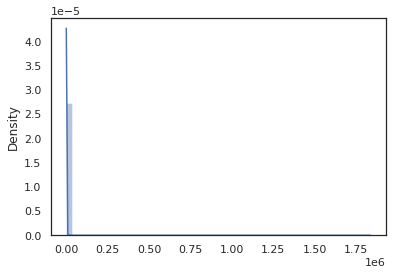

In [44]:
sns.distplot(df_raw_prot)

/home/rpoulos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

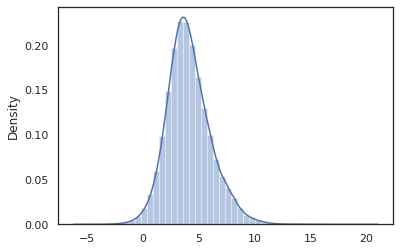

In [8]:
sns.distplot(np.log2(df_raw_prot))

In [9]:
df_sample_map = df_sample_map.drop(files_to_delete)
print('Files in sample mapping:',df_sample_map.shape[0])

Files in sample mapping: 6942


##### Make HEC QC plot

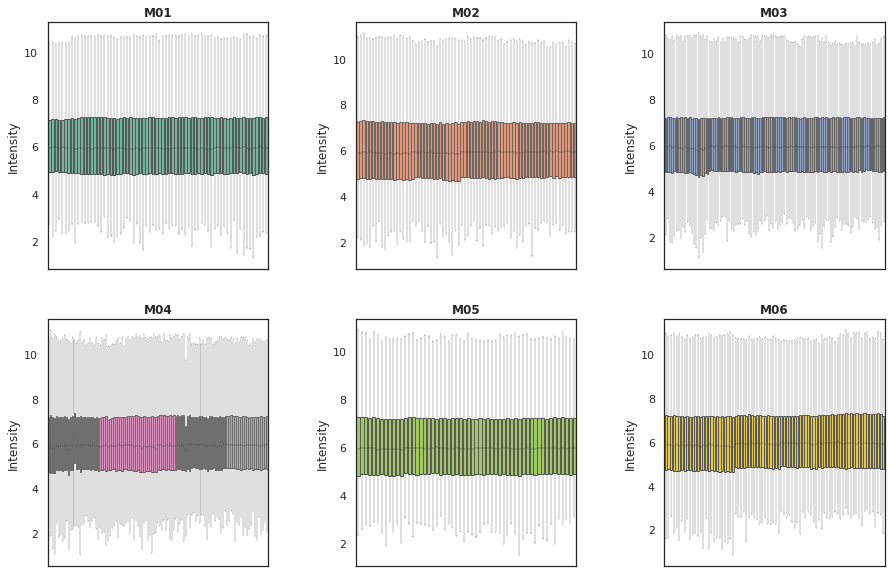

In [10]:
freq_proteins = df_raw_prot.count().to_frame('Freq').sort_values('Freq', ascending=False).index.tolist()[0:1000]
def make_hek_cleaning_plot(dtaframe):
    df_hek_std = dtaframe[freq_proteins].join(df_sample_map['Cell_line'])[lambda x: x.Cell_line == 'Control_HEK293T_std_H002'].drop('Cell_line',axis=1)
    curr_df = df_hek_std.unstack().to_frame('Intensity').reset_index().drop('level_0', axis=1).rename(columns={'level_1':'Sample'}).set_index('Sample').join(df_sample_map[['Date','Instrument']]).sort_values('Date').reset_index()
    fig = plt.figure(figsize=[15,10])
    for instrument in sorted(df_sample_map['Instrument'].unique().tolist()):
        ax = fig.add_subplot(2,3,int(instrument.split('0')[1]))
        plot_df = curr_df[lambda x: x.Instrument == instrument]
        plot = sns.boxplot(x='index', y='Intensity', data=plot_df, showfliers=False, color=instrument_colours[instrument], whiskerprops=outline_props, capprops=outline_props, medianprops=outline_props, boxprops=dict(linewidth=1))
        plot.set_xticklabels([])
        plot.set_title(instrument, weight='bold')
        plot.set_xlabel('')
    plt.subplots_adjust(wspace=0.4)
    plt.show()
make_hek_cleaning_plot(df_raw_prot.apply(np.log2))

##### Remove files below threshold

Files below threshold: 39


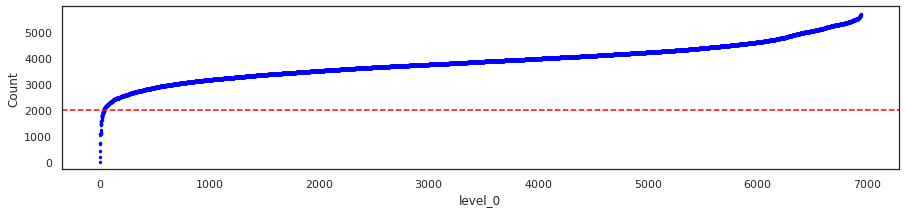

In [11]:
threshold = 2000
df_prot_counts = df_raw_prot.count(axis=1).to_frame('Count').sort_values('Count').reset_index().reset_index()
files_below_threshold = df_prot_counts[lambda x: x.Count < threshold]['index'].tolist()
print('Files below threshold:',len(files_below_threshold))
fig = plt.figure(figsize=[15,3])
plot = sns.scatterplot(x='level_0', y='Count', data=df_prot_counts, s=10, color='blue', edgecolor='blue')
plot.axhline(y=threshold, color='red', linestyle='--')
plt.show()

In [12]:
df_log = df_raw_prot.drop(files_below_threshold).dropna(how='all', axis=1).apply(np.log2)
df_sample_map = df_sample_map.drop(files_below_threshold)
print('Samples in protein matrix:',df_log.shape[0])
print('Proteins in protein matrix:',df_log.shape[1])
print('\nSamples in mapping:',df_sample_map.shape[0])

Samples in protein matrix: 6903
Proteins in protein matrix: 8498

Samples in mapping: 6903


##### Get samples with poor correlation

In [13]:
cell_lines_no_hek = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].unique().tolist()
df_corr = pd.DataFrame()
for cell_line in cell_lines_no_hek:
    samples = df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()
    df_corr.loc[cell_line,'Corr'] = df_log.loc[samples].transpose().corr().min().min()

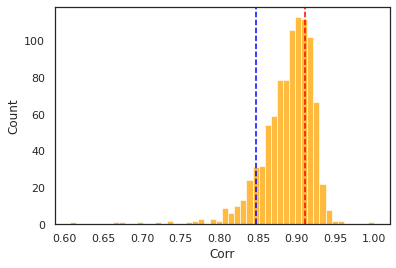

In [14]:
upper_bound = np.quantile(df_corr['Corr'], 0.75)
lower_bound = np.quantile(df_corr['Corr'], 0.10)
plot = sns.histplot(df_corr['Corr'], color='orange')
plot.axvline(x=upper_bound, linestyle='--', color='red')
plot.axvline(x=lower_bound, linestyle='--', color='blue')
plt.show()

In [15]:
possible_mix_ups = df_corr[lambda x: x.Corr < lower_bound].index.tolist()
mix_up_dict = {}
for cell_line in possible_mix_ups:
    samples = df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()
    curr_df = df_log.loc[samples].transpose().corr()
    min_corr_file = curr_df.mean().sort_values(ascending=True).to_frame().index.tolist()[0]
    all_corr_df = df_log.transpose().corrwith(df_log.transpose()[min_corr_file]).to_frame('Corr')
    max_corr = all_corr_df[lambda x: x.Corr > upper_bound].index.tolist()
    possible_mixed_samples = df_sample_map[lambda x: x.index.isin(max_corr)]['Cell_line'].unique().tolist()
    if len(possible_mixed_samples) > 1:
        mix_up_dict[cell_line] = possible_mixed_samples
print('Of',len(possible_mix_ups),'cell lines, found # possible mixups:',len(mix_up_dict))

Of 95 cell lines, found # possible mixups: 11


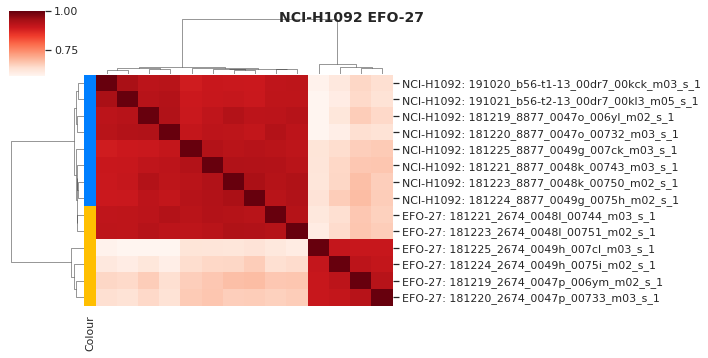

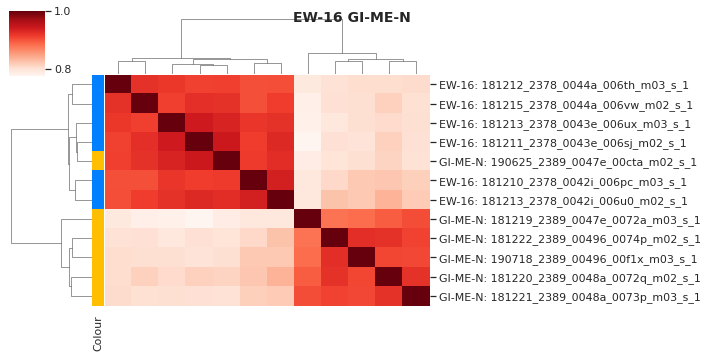

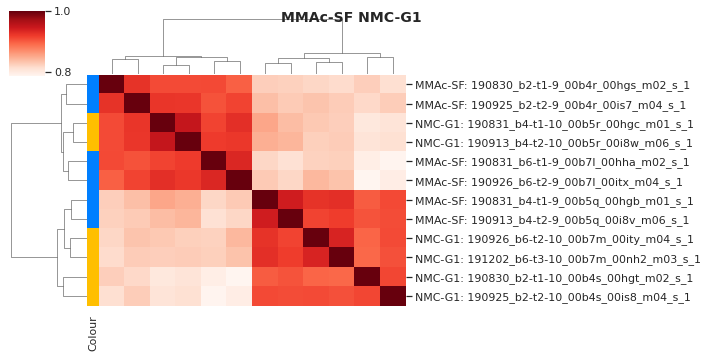

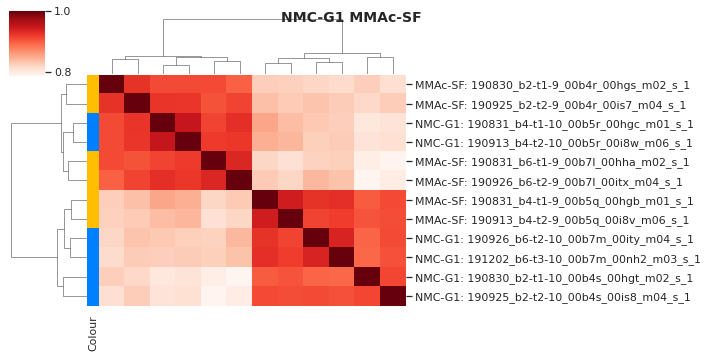

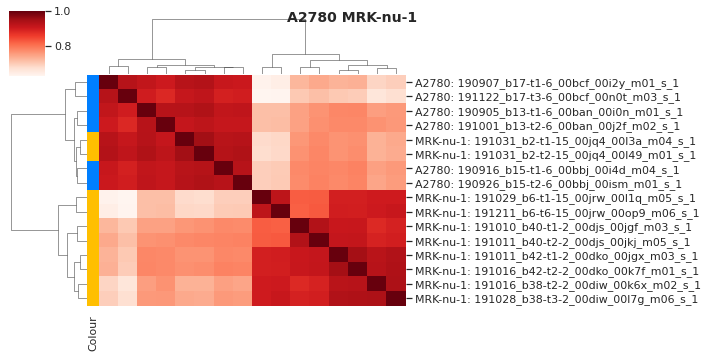

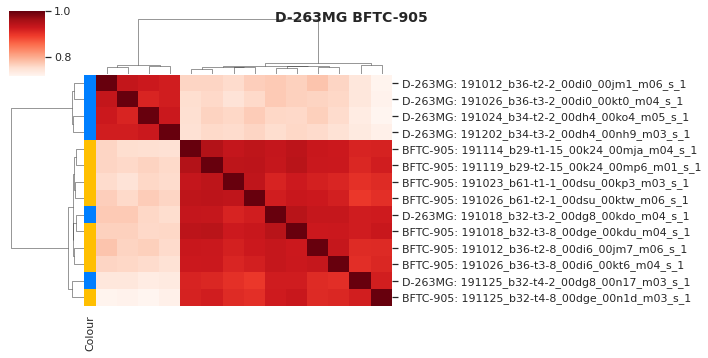

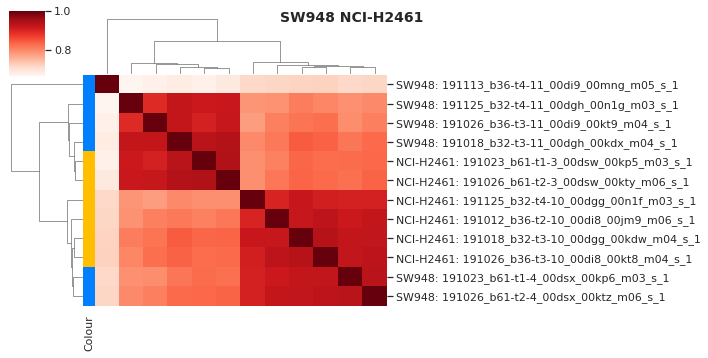

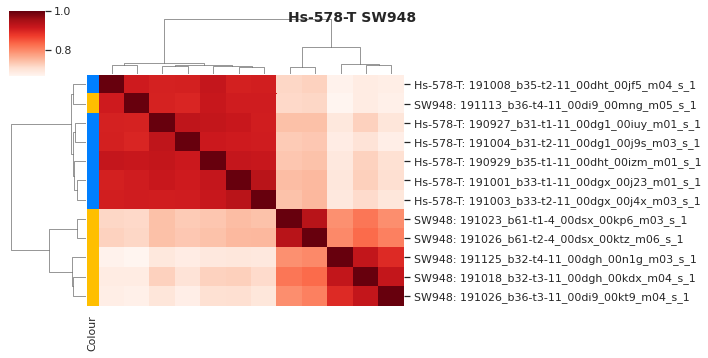

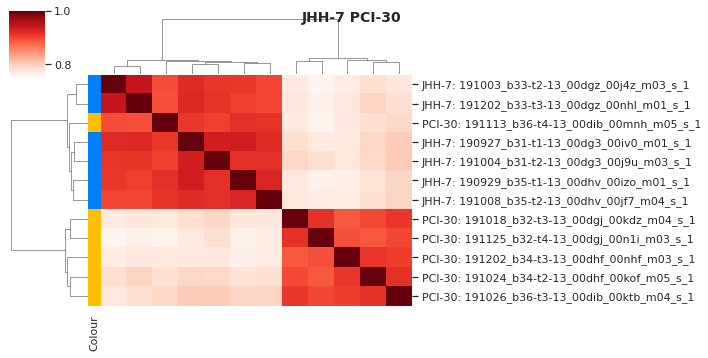

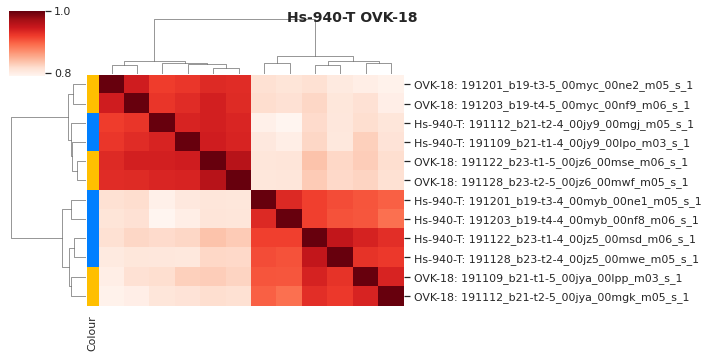

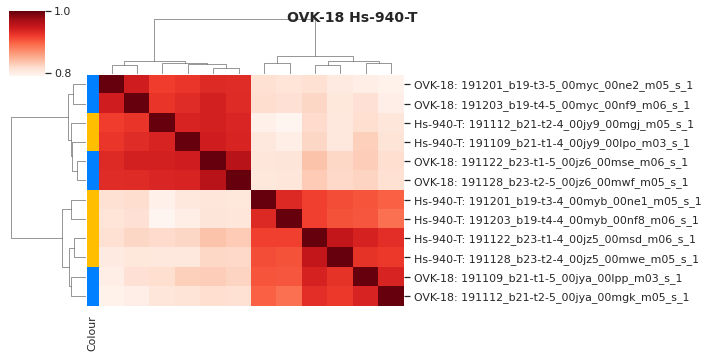

In [16]:
pdf = matplotlib.backends.backend_pdf.PdfPages('matrix_diann_normalised_051021/e0022_diann_visualise_possible_mix_ups.pdf')
for cell_line in mix_up_dict:
    plot_df = df_log.loc[df_sample_map[lambda x: x.Cell_line.isin(mix_up_dict[cell_line])].index.tolist()].transpose().corr()
    tmp_dict = {}
    for col in plot_df.columns.tolist():
        tmp_dict[col] = df_sample_map.loc[col,'Cell_line']+': '+col
    plot_df = plot_df.rename(columns=tmp_dict).transpose()
    df_colours = pd.DataFrame()
    num = 0
    curr_title = ''
    for line in mix_up_dict[cell_line]:
        curr_title += line+' '
        for file in df_sample_map[lambda x: x.Cell_line == line].index.tolist():
            df_colours.loc[line+': '+file,'Colour'] = colour_list[num]
        num += 2
    plot = sns.clustermap(plot_df, cmap='Reds', yticklabels=True, xticklabels=False, figsize=[10,5], vmin=plot_df.min().min(), vmax=1, row_colors=df_colours['Colour'])
    plot.fig.suptitle(curr_title, weight='bold', fontsize=14)
    pdf.savefig(plot.fig)
    plt.show()
pdf.close()

In [17]:
mixed_up_files = [
    '181223_2674_0048l_00751_m02_s_1',
    '181221_2674_0048l_00744_m03_s_1',
    '190625_2389_0047e_00cta_m02_s_1',
    '190831_b4-t1-10_00b5r_00hgc_m01_s_1',
    '190913_b4-t2-10_00b5r_00i8w_m06_s_1',
    '190831_b4-t1-9_00b5q_00hgb_m01_s_1',
    '190913_b4-t2-9_00b5q_00i8v_m06_s_1',
    '191031_b2-t1-15_00jq4_00l3a_m04_s_1',
    '191031_b2-t2-15_00jq4_00l49_m01_s_1',
    '191018_b32-t3-2_00dg8_00kdo_m04_s_1',
    '191125_b32-t4-2_00dg8_00n17_m03_s_1',
    '191023_b61-t1-3_00dsw_00kp5_m03_s_1',
    '191026_b61-t2-3_00dsw_00kty_m06_s_1',
    '191023_b61-t1-4_00dsx_00kp6_m03_s_1',
    '191026_b61-t2-4_00dsx_00ktz_m06_s_1',
    '191113_b36-t4-11_00di9_00mng_m05_s_1',
    '191113_b36-t4-13_00dib_00mnh_m05_s_1',
    '191112_b21-t2-4_00jy9_00mgj_m05_s_1',
    '191109_b21-t1-4_00jy9_00lpo_m03_s_1',
    '191109_b21-t1-5_00jya_00lpp_m03_s_1',
    '191112_b21-t2-5_00jya_00mgk_m05_s_1',
]
print('Total files in list:',len(mixed_up_files))
unique_mixed_up_files = list(dict.fromkeys(mixed_up_files))
print('Unique files in list:',len(unique_mixed_up_files),'\n')
for x in unique_mixed_up_files:
    print(x,'\t', df_sample_map.loc[x,'Cell_line'])

Total files in list: 21
Unique files in list: 21 

181223_2674_0048l_00751_m02_s_1 	 EFO-27
181221_2674_0048l_00744_m03_s_1 	 EFO-27
190625_2389_0047e_00cta_m02_s_1 	 GI-ME-N
190831_b4-t1-10_00b5r_00hgc_m01_s_1 	 NMC-G1
190913_b4-t2-10_00b5r_00i8w_m06_s_1 	 NMC-G1
190831_b4-t1-9_00b5q_00hgb_m01_s_1 	 MMAc-SF
190913_b4-t2-9_00b5q_00i8v_m06_s_1 	 MMAc-SF
191031_b2-t1-15_00jq4_00l3a_m04_s_1 	 MRK-nu-1
191031_b2-t2-15_00jq4_00l49_m01_s_1 	 MRK-nu-1
191018_b32-t3-2_00dg8_00kdo_m04_s_1 	 D-263MG
191125_b32-t4-2_00dg8_00n17_m03_s_1 	 D-263MG
191023_b61-t1-3_00dsw_00kp5_m03_s_1 	 NCI-H2461
191026_b61-t2-3_00dsw_00kty_m06_s_1 	 NCI-H2461
191023_b61-t1-4_00dsx_00kp6_m03_s_1 	 SW948
191026_b61-t2-4_00dsx_00ktz_m06_s_1 	 SW948
191113_b36-t4-11_00di9_00mng_m05_s_1 	 SW948
191113_b36-t4-13_00dib_00mnh_m05_s_1 	 PCI-30
191112_b21-t2-4_00jy9_00mgj_m05_s_1 	 Hs-940-T
191109_b21-t1-4_00jy9_00lpo_m03_s_1 	 Hs-940-T
191109_b21-t1-5_00jya_00lpp_m03_s_1 	 OVK-18
191112_b21-t2-5_00jya_00mgk_m05_s_1 	 OVK-18


##### Remove samples with possible mix-ups

In [18]:
df_log = df_log.drop(unique_mixed_up_files).dropna(how='all', axis=1)
df_sample_map = df_sample_map.drop(unique_mixed_up_files)
print('Samples in protein matrix:',df_log.shape[0])
print('Proteins in protein matrix:',df_log.shape[1])
print('\nSamples in mapping:',df_sample_map.shape[0])

Samples in protein matrix: 6882
Proteins in protein matrix: 8498

Samples in mapping: 6882


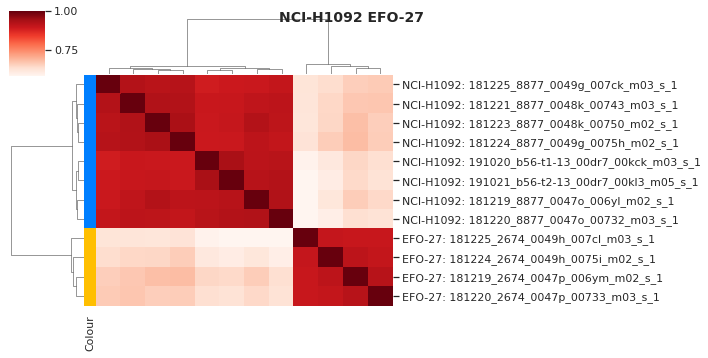

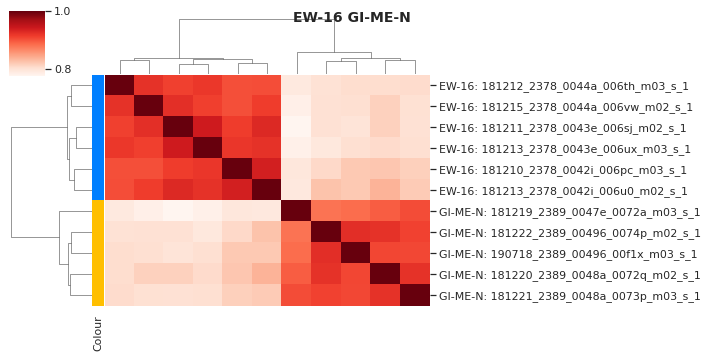

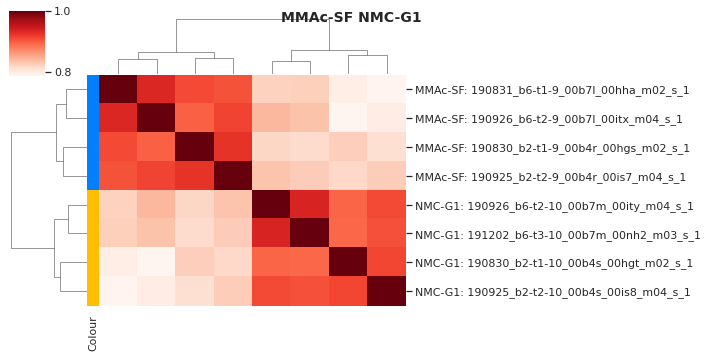

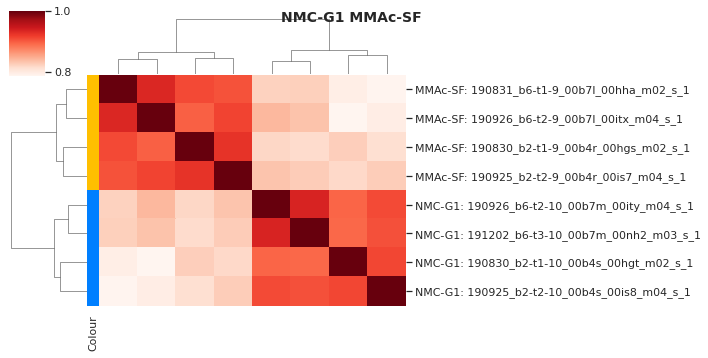

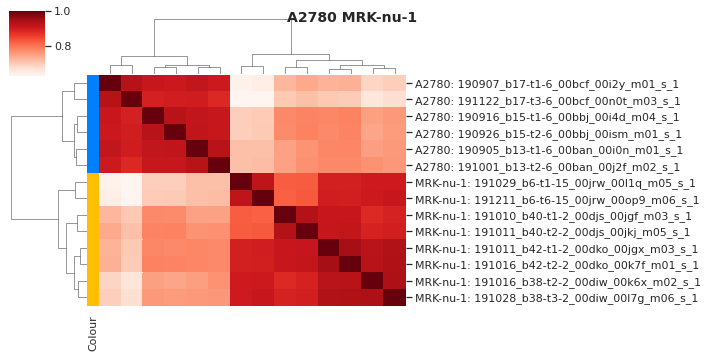

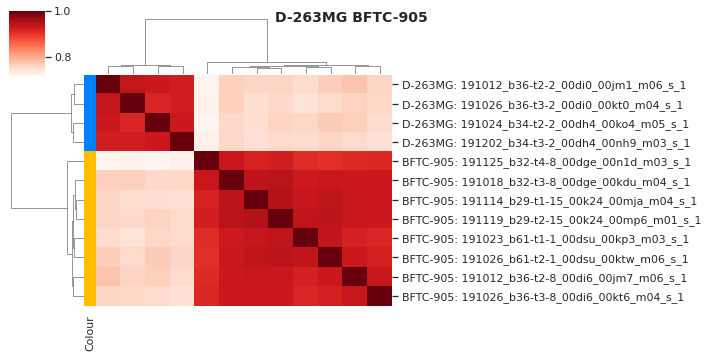

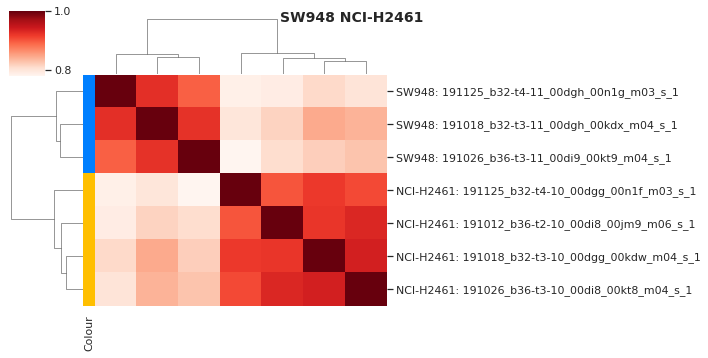

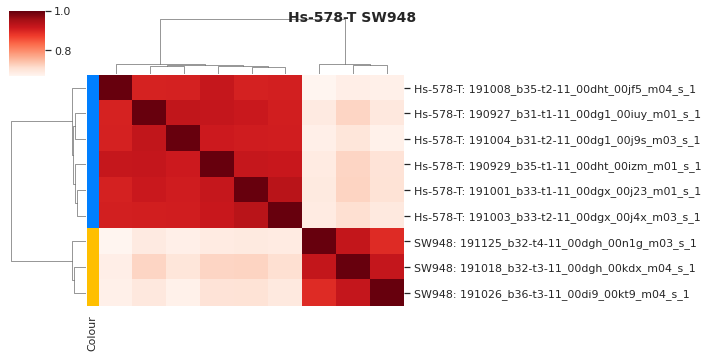

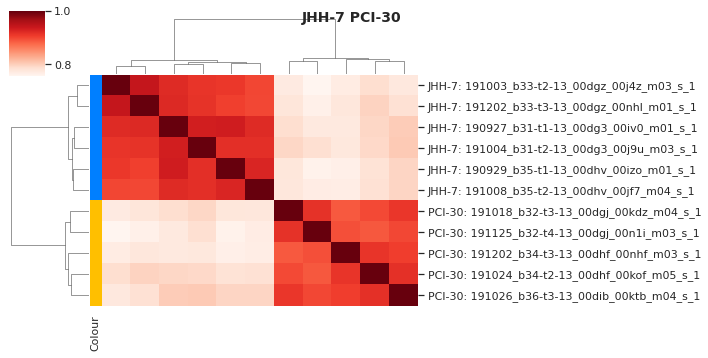

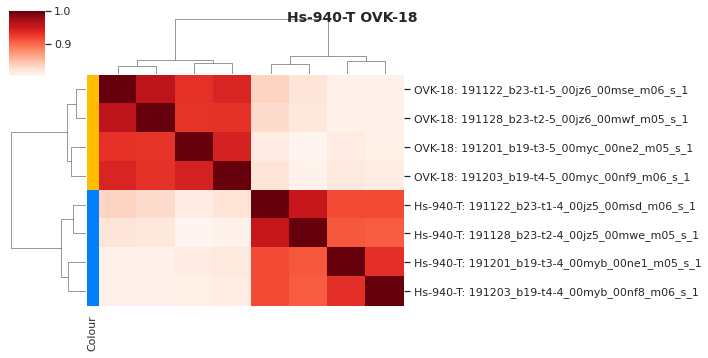

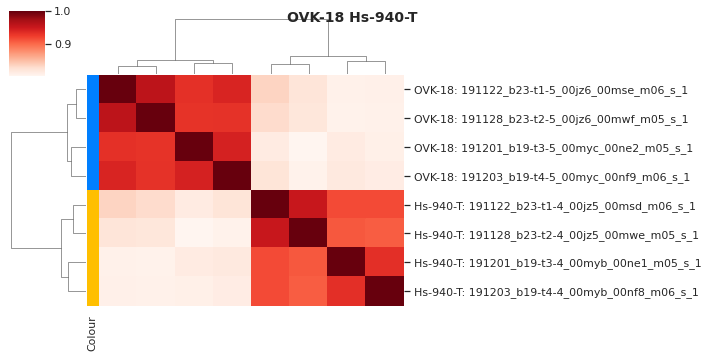

In [19]:
pdf = matplotlib.backends.backend_pdf.PdfPages('matrix_diann_normalised_051021/e0022_diann_visualise_after_mix_up_removal.pdf')
for cell_line in mix_up_dict:
    plot_df = df_log.loc[df_sample_map[lambda x: x.Cell_line.isin(mix_up_dict[cell_line])].index.tolist()].transpose().corr()
    tmp_dict = {}
    for col in plot_df.columns.tolist():
        tmp_dict[col] = df_sample_map.loc[col,'Cell_line']+': '+col
    plot_df = plot_df.rename(columns=tmp_dict).transpose()
    df_colours = pd.DataFrame()
    num = 0
    curr_title = ''
    for line in mix_up_dict[cell_line]:
        curr_title += line+' '
        for file in df_sample_map[lambda x: x.Cell_line == line].index.tolist():
            df_colours.loc[line+': '+file,'Colour'] = colour_list[num]
        num += 2
    plot = sns.clustermap(plot_df, cmap='Reds', yticklabels=True, xticklabels=False, figsize=[10,5], vmin=plot_df.min().min(), vmax=1, row_colors=df_colours['Colour'])
    plot.fig.suptitle(curr_title, weight='bold', fontsize=14)
    pdf.savefig(plot.fig)
    plt.show()
pdf.close()

##### Remove samples with other poor QC metrics

Cell lines with poor QC stats: 9


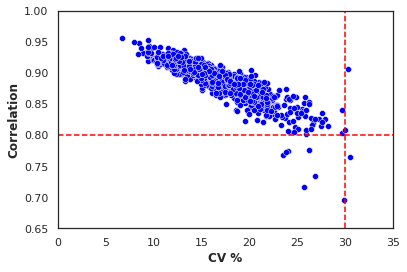

In [20]:
cell_lines_no_hek = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].unique().tolist()
frequent_proteins = (df_log.count()/df_log.shape[1]*100).to_frame('Freq')[lambda x: x.Freq > 80].index.tolist()
df_corr_afterqc = df_log[frequent_proteins].apply(lambda x: 2**x).join(df_sample_map['Cell_line']).groupby('Cell_line').apply(lambda x: (x.std()/x.mean())*100).groupby('Cell_line').median().to_frame('CV')
df_corr_afterqc = df_corr_afterqc.loc[cell_lines_no_hek]
for cell_line in cell_lines_no_hek:
    samples = df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()
    df_corr_afterqc.loc[cell_line,'Corr'] = df_log.loc[samples].transpose().corr().min().min()
cv_thresh = 30
corr_thresh = 0.8
poor_qc_lines = df_corr_afterqc[lambda x: (x.CV > cv_thresh) | (x.Corr < corr_thresh)].index.tolist()
print('Cell lines with poor QC stats:',len(poor_qc_lines))
plot = sns.scatterplot(x='CV', y='Corr', data=df_corr_afterqc, color='blue')
plot.axvline(x=cv_thresh, color='red', linestyle='--')
plot.axhline(y=corr_thresh, color='red', linestyle='--')
plot.set_xlabel('CV %', weight='bold')
plot.set_ylabel('Correlation', weight='bold')
plot.set_xlim(0,35)
plot.set_ylim(0.65,1)
plt.show()

181219_2117_0047v_0071t_m02_s_1
181220_2117_0047v_00739_m03_s_1
181221_2117_0048r_0074a_m03_s_1
181223_2117_0048r_00757_m02_s_1
181224_2117_0049n_0075o_m02_s_1
181225_2117_0049n_007cr_m03_s_1


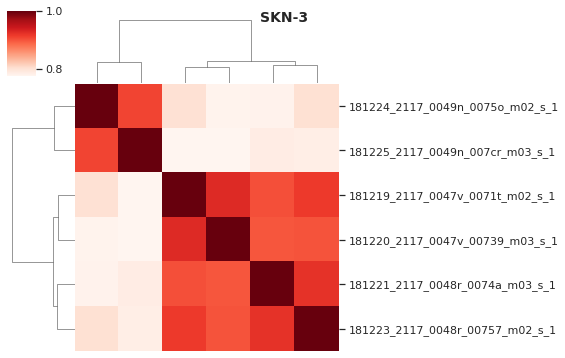

190102_6830_004h8_007jx_m02_s_1
190111_6830_004h8_007kv_m03_s_1
190115_6830_004i4_0080j_m04_s_1
190115_6830_004i4_00812_m06_s_1
190118_6830_004nq_0085o_m04_s_1
190119_6830_004nq_00865_m06_s_1


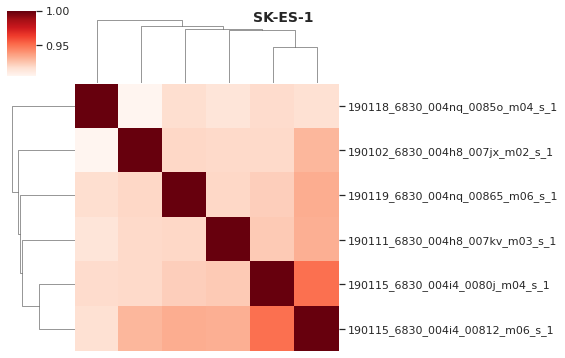

190520_7869_0083x_00b2s_m02_s_1
190522_7869_0088j_00bdd_m02_s_1
190522_7869_0088j_00beb_m04_s_1
190524_7869_007zx_00bgs_m04_s_1
190529_7869_007zx_00bl7_m03_s_1
190715_7869_0083x_00exp_m03_s_1
191015_b53-t1-16_00dpy_00k6b_m03_s_1
191019_b53-t2-16_00dpy_00kdk_m05_s_1


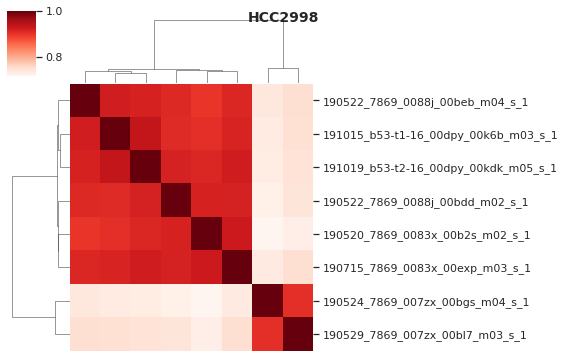

190522_8869_0088i_00bdc_m02_s_1
190522_8869_0088i_00bea_m04_s_1
190524_8869_007zw_00bgr_m04_s_1
190529_8869_007zw_00bl6_m03_s_1
190715_8869_0083w_00exo_m03_s_1
190812_8869_0083w_00gdu_m05_s_1
190831_b6-t1-17_00b7t_00hhi_m02_s_1
190926_b6-t2-17_00b7t_00iu5_m04_s_1


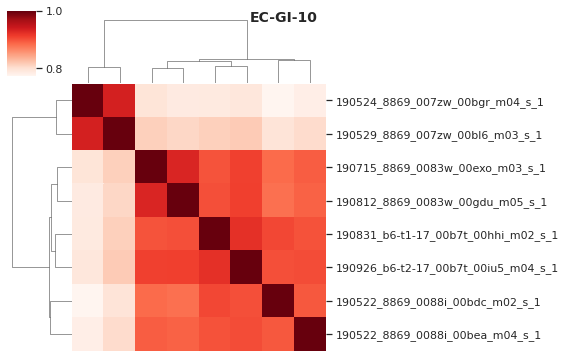

190531_6992_008cm_00bm4_m02_s_1
190603_6992_008di_00bvr_m02_s_1
190605_6992_008ee_00byu_m02_s_1
190613_6992_008di_00c1i_m04_s_1
190617_6992_008cm_00c4v_m03_s_1
190620_6992_008ee_00c89_m03_s_1
190911_b20-t1-16_00dba_00i6l_m01_s_1
190920_b20-t3-16_00dba_00ikg_m05_s_1


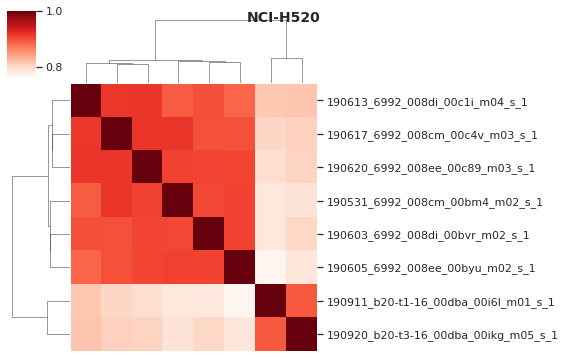

190908_b21-t1-14_00dbo_00i3n_m01_s_1
190918_b19-t1-14_00das_00ijc_m04_s_1
190923_b23-t1-14_00dck_00ijx_m06_s_1
190930_b23-t3-14_00dck_00j17_m06_s_1
191004_b21-t2-14_00dbo_00j9e_m02_s_1
191113_b19-t3-14_00das_00mnc_m05_s_1


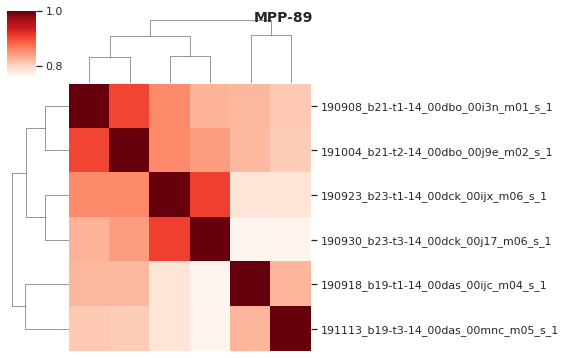

190927_b31-t1-6_00dfw_00iut_m01_s_1
191001_b33-t1-6_00dgs_00j1y_m01_s_1
191003_b33-t2-6_00dgs_00j4s_m03_s_1
191004_b31-t2-6_00dfw_00j9n_m03_s_1
191008_b35-t2-6_00dho_00jf0_m04_s_1
191008_b35-t3-6_00dho_00jfs_m01_s_1


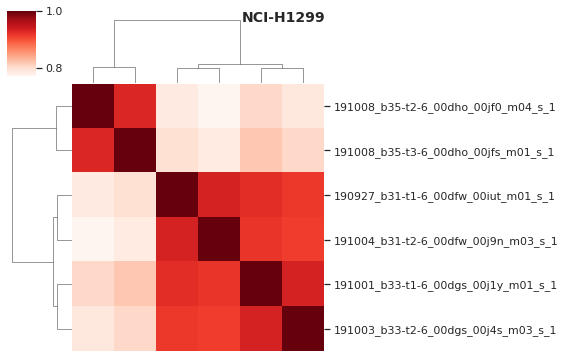

191010_b40-t1-5_00djv_00jgi_m03_s_1
191011_b42-t1-5_00dkr_00jh0_m03_s_1
191011_b40-t2-5_00djv_00jkm_m05_s_1
191016_b38-t2-5_00diz_00k70_m02_s_1
191016_b42-t2-5_00dkr_00k7i_m01_s_1
191028_b38-t3-5_00diz_00l7j_m06_s_1
191029_b3-t1-15_00jqk_00l18_m02_s_1
191216_b3-t2-15_00jqk_00l58_m06_s_1
191202_b5-t3-15_00mxq_00neu_m06_s_1
191209_b5-t4-15_00mxq_00oab_m05_s_1


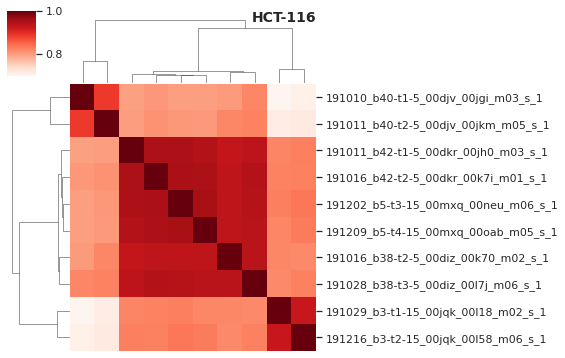

191029_b6-t1-4_00jrl_00l1f_m05_s_1
191031_b2-t1-4_00jpt_00l2z_m04_s_1
191031_b2-t2-4_00jpt_00l3y_m01_s_1
191101_b4-t2-4_00jqp_00l5x_m04_s_1
191206_b4-t3-4_00jqp_00nu7_m05_s_1
191211_b6-t6-4_00jrl_00ooy_m06_s_1


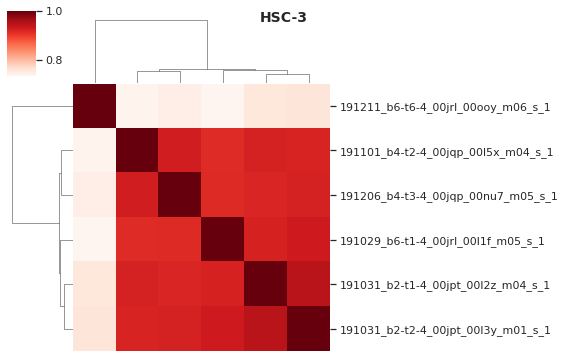

In [21]:
pdf = matplotlib.backends.backend_pdf.PdfPages('matrix_diann_normalised_051021/e0022_diann_visualise_poor_qc_samples.pdf')
for cell_line in poor_qc_lines:
    curr_df = df_log.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()].transpose().corr()
    plot = sns.clustermap(curr_df, cmap='Reds', yticklabels=True, xticklabels=False, figsize=[8,5])
    [print(x) for x in curr_df.index.tolist()]
    plot.fig.suptitle(cell_line, weight='bold', fontsize=14)
    pdf.savefig(plot.fig)
    plt.show()
pdf.close()

In [22]:
poor_qc_files = [
    '181224_2117_0049n_0075o_m02_s_1',
    '181225_2117_0049n_007cr_m03_s_1',
    '190118_6830_004nq_0085o_m04_s_1',
    '190524_7869_007zx_00bgs_m04_s_1',
    '190529_7869_007zx_00bl7_m03_s_1',
    '190524_8869_007zw_00bgr_m04_s_1',
    '190529_8869_007zw_00bl6_m03_s_1',
    '190911_b20-t1-16_00dba_00i6l_m01_s_1',
    '190920_b20-t3-16_00dba_00ikg_m05_s_1',
    '190918_b19-t1-14_00das_00ijc_m04_s_1',
    '191113_b19-t3-14_00das_00mnc_m05_s_1',
    '191008_b35-t2-6_00dho_00jf0_m04_s_1',
    '191008_b35-t3-6_00dho_00jfs_m01_s_1',
    '191010_b40-t1-5_00djv_00jgi_m03_s_1',
    '191011_b40-t2-5_00djv_00jkm_m05_s_1',
    '191029_b3-t1-15_00jqk_00l18_m02_s_1',
    '191216_b3-t2-15_00jqk_00l58_m06_s_1',
    '191211_b6-t6-4_00jrl_00ooy_m06_s_1']

print('Files to remove due to poor QC:',len(poor_qc_files))
print('Cell lines affected:',len(df_sample_map.loc[poor_qc_files]['Cell_line'].unique().tolist()))

Files to remove due to poor QC: 18
Cell lines affected: 9


In [23]:
df_log = df_log.drop(poor_qc_files).dropna(how='all', axis=1)
df_sample_map = df_sample_map.drop(poor_qc_files)

print('Samples in protein matrix:',df_log.shape[0])
print('Proteins in protein matrix:',df_log.shape[1])
print('\nSamples in mapping:',df_sample_map.shape[0])

Samples in protein matrix: 6864
Proteins in protein matrix: 8498

Samples in mapping: 6864


Remaining cell lines with poor QC stats: 2


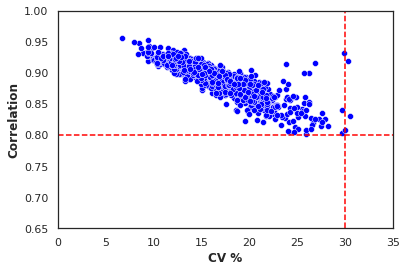

In [24]:
cell_lines_no_hek = df_sample_map[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]['Cell_line'].unique().tolist()
frequent_proteins = (df_log.count()/df_log.shape[1]*100).to_frame('Freq')[lambda x: x.Freq > 80].index.tolist()
df_corr_after2ndqc = df_log[frequent_proteins].apply(lambda x: 2**x).join(df_sample_map['Cell_line']).groupby('Cell_line').apply(lambda x: (x.std()/x.mean())*100).groupby('Cell_line').median().to_frame('CV')
df_corr_after2ndqc = df_corr_afterqc.loc[cell_lines_no_hek]
for cell_line in cell_lines_no_hek:
    samples = df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()
    df_corr_after2ndqc.loc[cell_line,'Corr'] = df_log.loc[samples].transpose().corr().min().min()
remaining_poor_qc_lines = df_corr_after2ndqc[lambda x: (x.CV > cv_thresh) | (x.Corr < corr_thresh)].index.tolist()
print('Remaining cell lines with poor QC stats:',len(remaining_poor_qc_lines))
plot = sns.scatterplot(x='CV', y='Corr', data=df_corr_after2ndqc, color='blue')
plot.axvline(x=cv_thresh, color='red', linestyle='--')
plot.axhline(y=corr_thresh, color='red', linestyle='--')
plot.set_xlabel('CV %', weight='bold')
plot.set_ylabel('Correlation', weight='bold')
plot.set_xlim(0,35)
plot.set_ylim(0.65,1)
plt.show()

190102_6830_004h8_007jx_m02_s_1
190111_6830_004h8_007kv_m03_s_1
190115_6830_004i4_0080j_m04_s_1
190115_6830_004i4_00812_m06_s_1
190119_6830_004nq_00865_m06_s_1


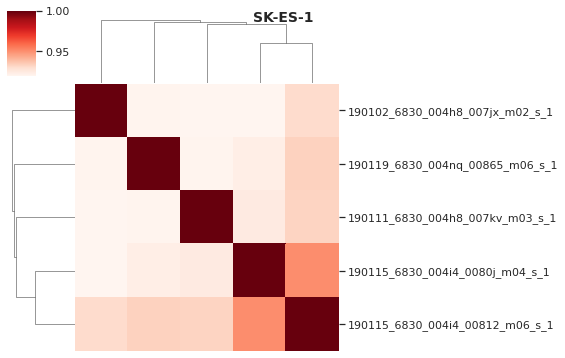

190908_b21-t1-14_00dbo_00i3n_m01_s_1
190923_b23-t1-14_00dck_00ijx_m06_s_1
190930_b23-t3-14_00dck_00j17_m06_s_1
191004_b21-t2-14_00dbo_00j9e_m02_s_1


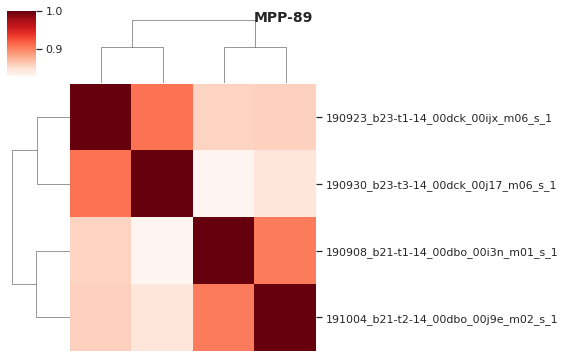

In [25]:
pdf = matplotlib.backends.backend_pdf.PdfPages('matrix_diann_normalised_051021/e0022_diann_visualise_remaining_poor_qc_samples.pdf')
for cell_line in remaining_poor_qc_lines:
    curr_df = df_log.loc[df_sample_map[lambda x: x.Cell_line == cell_line].index.tolist()].transpose().corr()
    plot = sns.clustermap(curr_df, cmap='Reds', yticklabels=True, xticklabels=False, figsize=[8,5])
    [print(x) for x in curr_df.index.tolist()]
    plot.fig.suptitle(cell_line, weight='bold', fontsize=14)
    pdf.savefig(plot.fig)
    plt.show()
pdf.close()

##### Finalise frozen matrix - replicates

In [26]:
prot_dict = pd.read_csv('matrix_diann_normalised_051021/uniprot-yourlist_M20211007A084FC58F6BBA219896F365D15F2EB44220407N.tab', sep='\t')
prot_dict['ID'] = prot_dict['Entry']+';'+prot_dict['Entry name']
prot_dict = prot_dict.set_index('Entry').to_dict()['ID']
print('Proteins not accounted for:',len([x for x in df_log.columns.tolist() if x not in list(prot_dict.keys())]))
df_log = df_log.rename(columns=prot_dict)
print('Number of samples:',df_log.shape[0])
print('Number of proteins:',df_log.shape[1])
get_missing_values(df_log)
df_log.to_csv('matrix_diann_normalised_051021/e0022_diann_051021_frozen_matrix.txt', sep='\t')

Proteins not accounted for: 0
Number of samples: 6864
Number of proteins: 8498
Missing values: 54.45 %


/home/rpoulos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

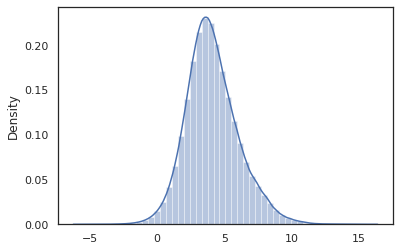

In [27]:
sns.distplot(df_log)

##### Finalise frozen matrix - averaged

In [28]:
df_log_ave = df_log.join(df_sample_map['Project_Identifier']).groupby('Project_Identifier').mean()[lambda x: ~x.index.str.contains('Control_HEK293T')]
print('Number of samples:',df_log_ave.shape[0])
print('Number of proteins:',df_log_ave.shape[1])
get_missing_values(df_log_ave)
df_log_ave.to_csv('matrix_diann_normalised_051021/e0022_diann_051021_frozen_matrix_averaged.txt', sep='\t')

Number of samples: 949
Number of proteins: 8498
Missing values: 38.71 %


/home/rpoulos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

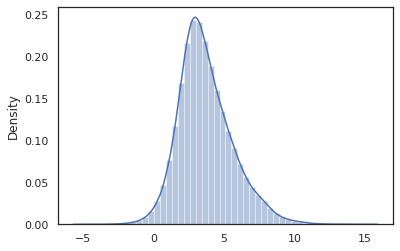

In [29]:
sns.distplot(df_log_ave)

In [48]:
df_log_ave.count(axis=1).mean()

5208.492096944152

##### Finalise working matrix - remove single hit peptides (sample-wise)

In [30]:
df_counts_sample = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_peptide_counts_samplewise.txt', sep='\t')
df_counts_sample = df_counts_sample[lambda x: ~x['Protein.Ids'].isin(['RT-Kit-WR','RMISv2','ProCal'])]
df_counts_sample['Protein'] = df_counts_sample['Protein.Ids'].map(prot_dict)
df_counts_sample_wide = pd.pivot_table(df_counts_sample, columns='Protein',index=['Run'],values='Modified.Sequence')
df_counts_sample_wide = df_counts_sample_wide[lambda x: x.index.isin(df_sample_map.index.tolist())]
df_counts_sample_wide.to_csv('matrix_diann_normalised_051021/peptide_counts_per_sample_wide.txt', sep='\t')
print('Shape:', df_counts_sample_wide.shape)

Shape: (6864, 8498)


In [31]:
df_working = df_log.copy()
print('Before removing sample-wise single peptide proteins:')
get_missing_values(df_working)
df_working[df_counts_sample_wide == 1] = np.nan
print('\nAfter removing sample-wise single peptide proteins:')
get_missing_values(df_working)

Before removing sample-wise single peptide proteins:
Missing values: 54.45 %

After removing sample-wise single peptide proteins:
Missing values: 67.82 %


##### Finalise working matrix - remove single hit proteins (cohort-wise) and non human proteins

In [32]:
non_human_proteins = [x for x in df_log.columns.tolist() if '_HUMAN' not in x]
print('Non-human proteins:',len(non_human_proteins))

Non-human proteins: 31


In [33]:
df_counts_cohort = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_peptide_counts_cohortwise.txt', sep='\t')
df_counts_cohort = df_counts_cohort[lambda x: ~x['Protein.Ids'].isin(['RT-Kit-WR','RMISv2','ProCal'])]
df_counts_cohort['Protein'] = df_counts_cohort['Protein.Ids'].map(prot_dict)

single_peptide_proteins = df_counts_cohort[lambda x: x.Peptides == 1].Protein.tolist()
print('Proteins with single peptide support:', len(single_peptide_proteins))

multiple_peptide_proteins = df_counts_cohort[lambda x: x.Peptides > 1].Protein.tolist()
print('Proteins with multiple peptide support:', len(multiple_peptide_proteins))

Proteins with single peptide support: 1797
Proteins with multiple peptide support: 6701


In [34]:
pd.DataFrame(index=single_peptide_proteins).reset_index().to_csv('matrix_diann_normalised_051021/single_peptide_proteins.txt', sep='\t', index=False)
pd.DataFrame(index=multiple_peptide_proteins).reset_index().to_csv('matrix_diann_normalised_051021/multiple_peptide_proteins.txt', sep='\t', index=False)

In [43]:
print('Non-human proteins with multiple peptide support:', len([x for x in non_human_proteins if x in multiple_peptide_proteins]))

Non-human proteins with multiple peptide support: 2


In [35]:
df_working = df_working.drop(list(set(single_peptide_proteins+non_human_proteins)), axis=1)
get_missing_values(df_working)

Missing values: 59.19 %


##### Finalise working matrix - replicates

In [36]:
df_working = df_working.drop(df_sample_map[lambda x: x.Cell_line.str.contains('Control_HEK293T')].index.tolist()).dropna(how='all', axis=1)
print('Number of samples:',df_working.shape[0])
print('Number of proteins:',df_working.shape[1])
get_missing_values(df_working)
df_working.to_csv('matrix_diann_normalised_051021/e0022_diann_051021_working_matrix_replicates.txt', sep='\t')

Number of samples: 5800
Number of proteins: 6692
Missing values: 60.89 %


/home/rpoulos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

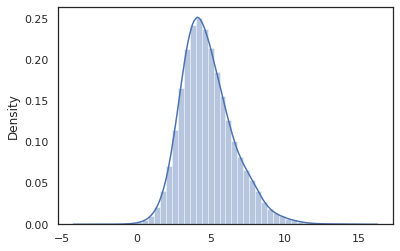

In [37]:
sns.distplot(df_working)

##### Finalise working matrix - averaged

In [38]:
df_working_ave = df_working.join(df_sample_map['Project_Identifier']).groupby('Project_Identifier').mean()
print('Number of samples:',df_working_ave.shape[0])
print('Number of proteins:',df_working_ave.shape[1])
get_missing_values(df_working_ave)
df_working_ave.to_csv('matrix_diann_normalised_051021/e0022_diann_051021_working_matrix_averaged.txt', sep='\t')

Number of samples: 949
Number of proteins: 6692
Missing values: 47.91 %


/home/rpoulos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

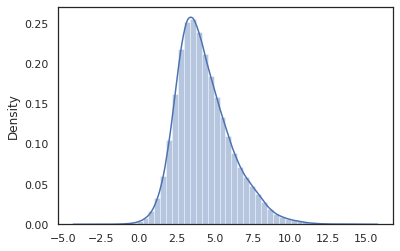

In [39]:
sns.distplot(df_working_ave)

##### Write out sample mapping files

In [40]:
df_sample_map.to_csv('matrix_diann_normalised_051021/e0022_diann_051021_sample_mapping_replicates.txt', sep='\t')
print('Shape:',df_sample_map.shape)

Shape: (6864, 12)


In [41]:
df_map = df_sample_map.reset_index()[['Cell_line','SIDM','Project_Identifier','Tissue_type','Cancer_type','Cancer_subtype']].drop_duplicates()[lambda x: ~x.Cell_line.str.contains('Control_HEK293T')]
df_map.to_csv('matrix_diann_normalised_051021/e0022_diann_051021_sample_mapping_averaged.txt', sep='\t', index=False)
print('Shape:',df_map.shape)

Shape: (949, 6)


##### Generate Table S7

In [54]:
full_file_list = pd.read_csv('Generate_sample_mapping/E0022_P06_sample_map.txt', sep='\t')['Automatic_MS_filename']
df_table_s7 = pd.DataFrame(index=full_file_list)
df_table_s7.loc[df_sample_map.index.tolist(),'Status'] = 'Included'
df_table_s7.loc['191206_hek-qcs_00j8w_00ntp_m05_s_1','Status'] = 'Excluded - no peptides'
df_table_s7.loc[p01_files,'Status'] = 'Excluded - pilot batch'
df_table_s7.loc[sw900_files,'Status'] = 'Excluded - failed STR profiling'
df_table_s7.loc[unique_mixed_up_files,'Status'] = 'Excluded - poor replicate correlation'
df_table_s7.loc[poor_qc_files,'Status'] = 'Excluded - poor replicate correlation'
df_table_s7.loc[files_below_threshold,'Status'] = 'Excluded - less than 2000 proteins'
df_table_s7.to_excel('figures/Table_S7.xlsx')

##### Generate Table S2

In [57]:
writer = pd.ExcelWriter('figures/SupplementaryTable2.xlsx')
df_log.to_excel(writer,'TableS2a')
df_log_ave.to_excel(writer,'TableS2b')
df_working.to_excel(writer,'TableS2c')
df_working_ave.to_excel(writer,'TableS2d')
df_counts_sample_wide.to_excel(writer,'TableS2e')
writer.save()